<a href="https://colab.research.google.com/github/Will1202/Internship-learning-note/blob/Advanced-OCR-Comparison-and-Layout-Aware-Extraction/Extracting_Text_%26_Bounding_Boxes_from_Scanned_PDFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =======================
# 📌 Step 1: Install Dependencies
# =======================
!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 67.3 MB/s eta 0:00:00


In [4]:
# =======================
# 📌 Step 2: Import Libraries
# =======================
import fitz  # PyMuPDF
import cv2
import pytesseract
import numpy as np
from PIL import Image


In [5]:
# =======================
# 📌 Step 3: Load Scanned PDF
# =======================
# Upload "sample_mortgage_document.pdf" manually in Colab
from google.colab import files

uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]  # Get uploaded file name

# Open the scanned mortgage document
doc = fitz.open(pdf_path)

Saving sample_mortgage_document.pdf to sample_mortgage_document.pdf


In [ ]:
# =======================
# 📌 Step 4: Try Extracting Text Without OCR (Will Fail)
# =======================
page = doc[0]
text = page.get_text("text")  # Normal text extraction
print("Extracted Text:", text)  # Expecting empty or incorrect output

Extracted Text: 


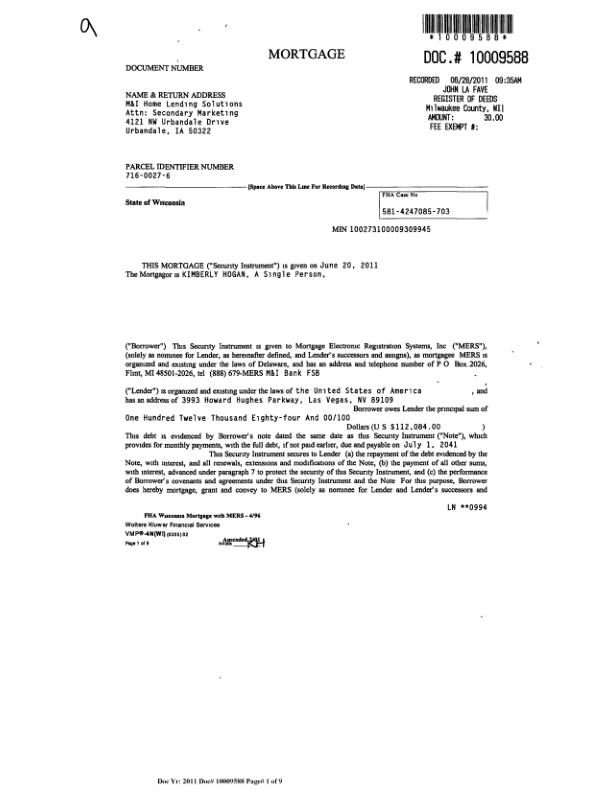

In [ ]:
# =======================
# 📌 Step 5: Convert PDF to Image for OCR
# =======================
pix = page.get_pixmap()
img = np.array(Image.frombytes("RGB", [pix.width, pix.height], pix.samples))
display(Image.fromarray(img))

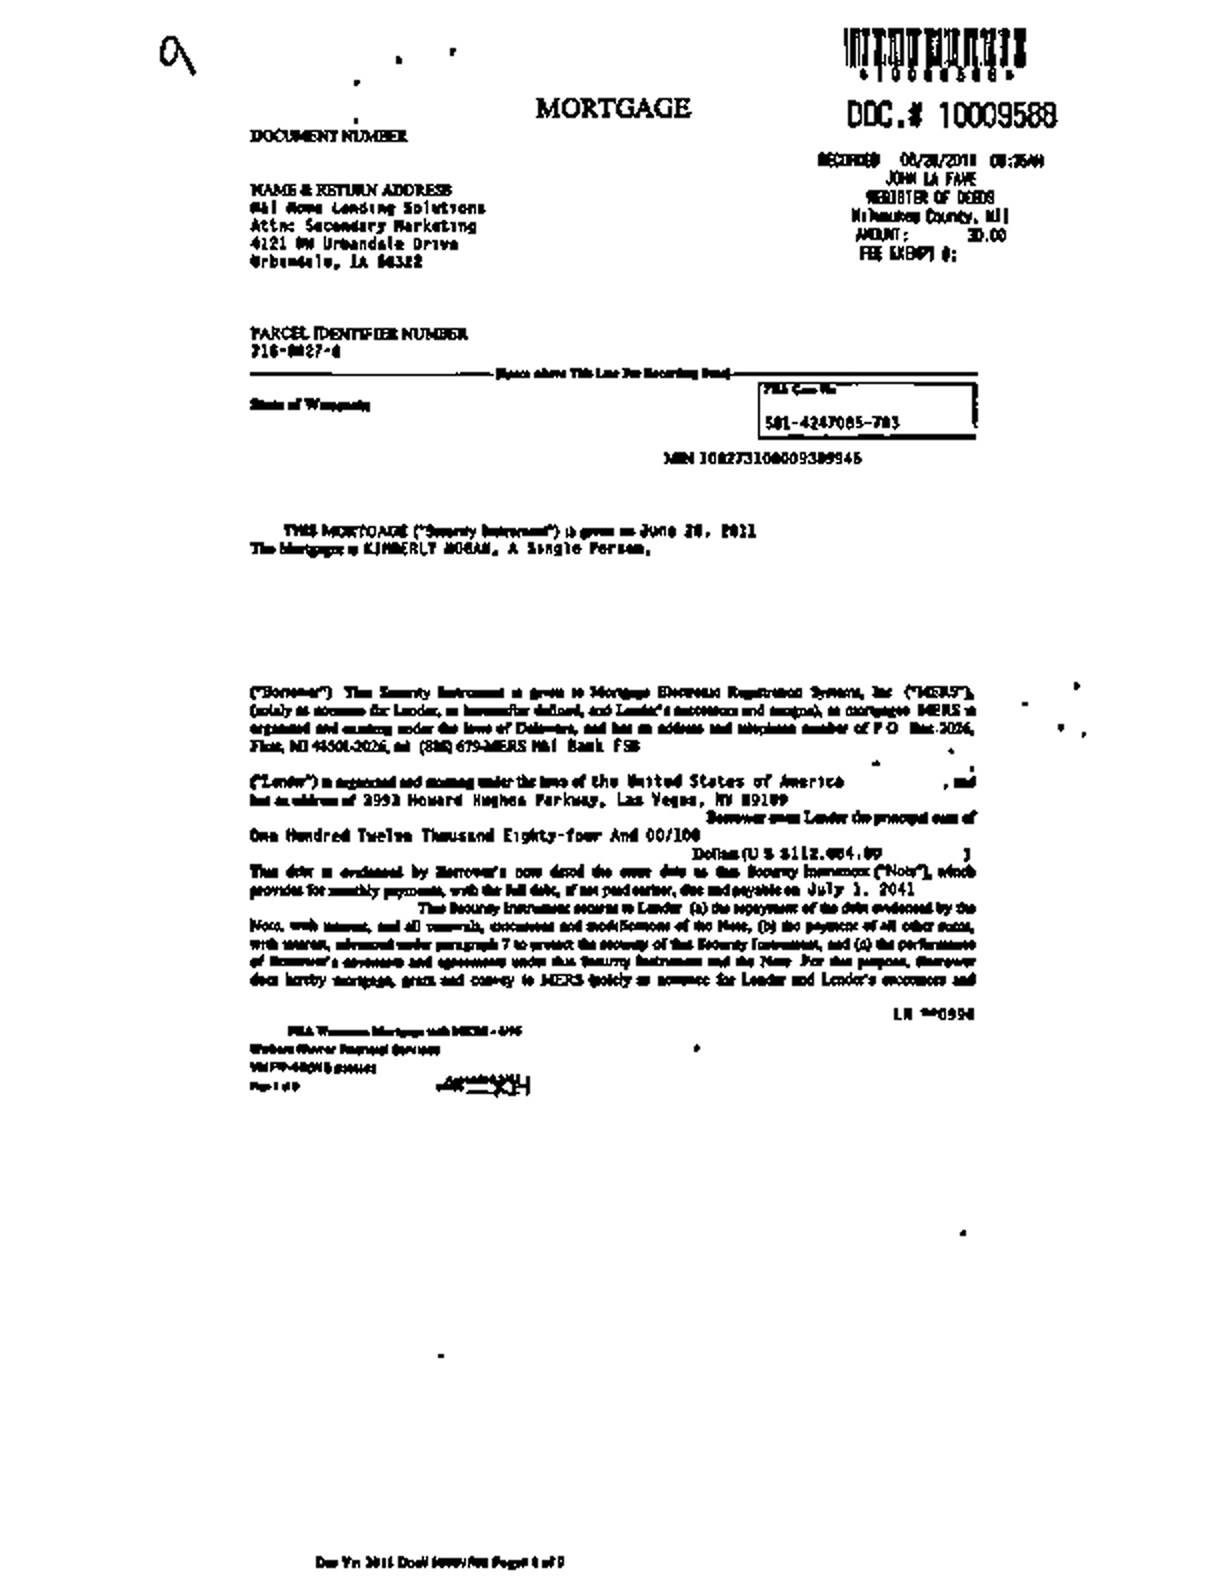

In [ ]:

# =======================
# 📌 Step 6: Preprocess Image for Better OCR Accuracy
# =======================

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply Adaptive Thresholding for contrast enhancement
gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Apply Bilateral Filtering to reduce noise while preserving edges
gray = cv2.bilateralFilter(gray, 9, 75, 75)

# Resize image for better OCR accuracy (Tesseract performs better on larger text)
scale_percent = 200  # Increase image size by 200%
width = int(gray.shape[1] * scale_percent / 100)
height = int(gray.shape[0] * scale_percent / 100)
gray = cv2.resize(gray, (width, height), interpolation=cv2.INTER_CUBIC)

# Show the preprocessed image
display(Image.fromarray(gray))


In [2]:
# =======================
# 📌 Step 7.1: Perform OCR on the Image
# =======================
# Use optimized Tesseract OCR configurations
custom_config = r'--oem 3 -l eng'
ocr_text = pytesseract.image_to_string(gray, config=custom_config)


print("OCR Extracted Text:\n", ocr_text)

# =======================
# 📌 Step 7.2: Extract Bounding Boxes from OCR Output
# =======================

ocr_data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

# Print first 5 extracted words with bounding boxes
for i in range(5):
    print(f"Word: {ocr_data['text'][i]}, BBox: ({ocr_data['left'][i]}, {ocr_data['top'][i]}, {ocr_data['width'][i]}, {ocr_data['height'][i]})")


NameError: name 'pytesseract' is not defined

In [1]:
# =======================
# 📌 Step 8: Post-OCR Processing & Extracting Key Information
# =======================

import re
import json

# 📌 Step 8.1: Preprocess OCR Text (Cleaning & Formatting)
ocr_text = " ".join(ocr_text.split())  # Remove extra spaces & newlines
ocr_text = re.sub(r'[^a-zA-Z0-9\s,.%-]', '', ocr_text)  # Remove special chars

# 📌 Step 8.2: Fix Common OCR Errors
ocr_text = re.sub(r'\bL0AN\b', 'LOAN', ocr_text, flags=re.IGNORECASE)
ocr_text = re.sub(r'\bM0RTGAGE\b', 'MORTGAGE', ocr_text, flags=re.IGNORECASE)
ocr_text = re.sub(r'\b1NTEREST\b', 'INTEREST', ocr_text, flags=re.IGNORECASE)


print("Final Cleaned OCR Text:\n", ocr_text)


NameError: name 'ocr_text' is not defined

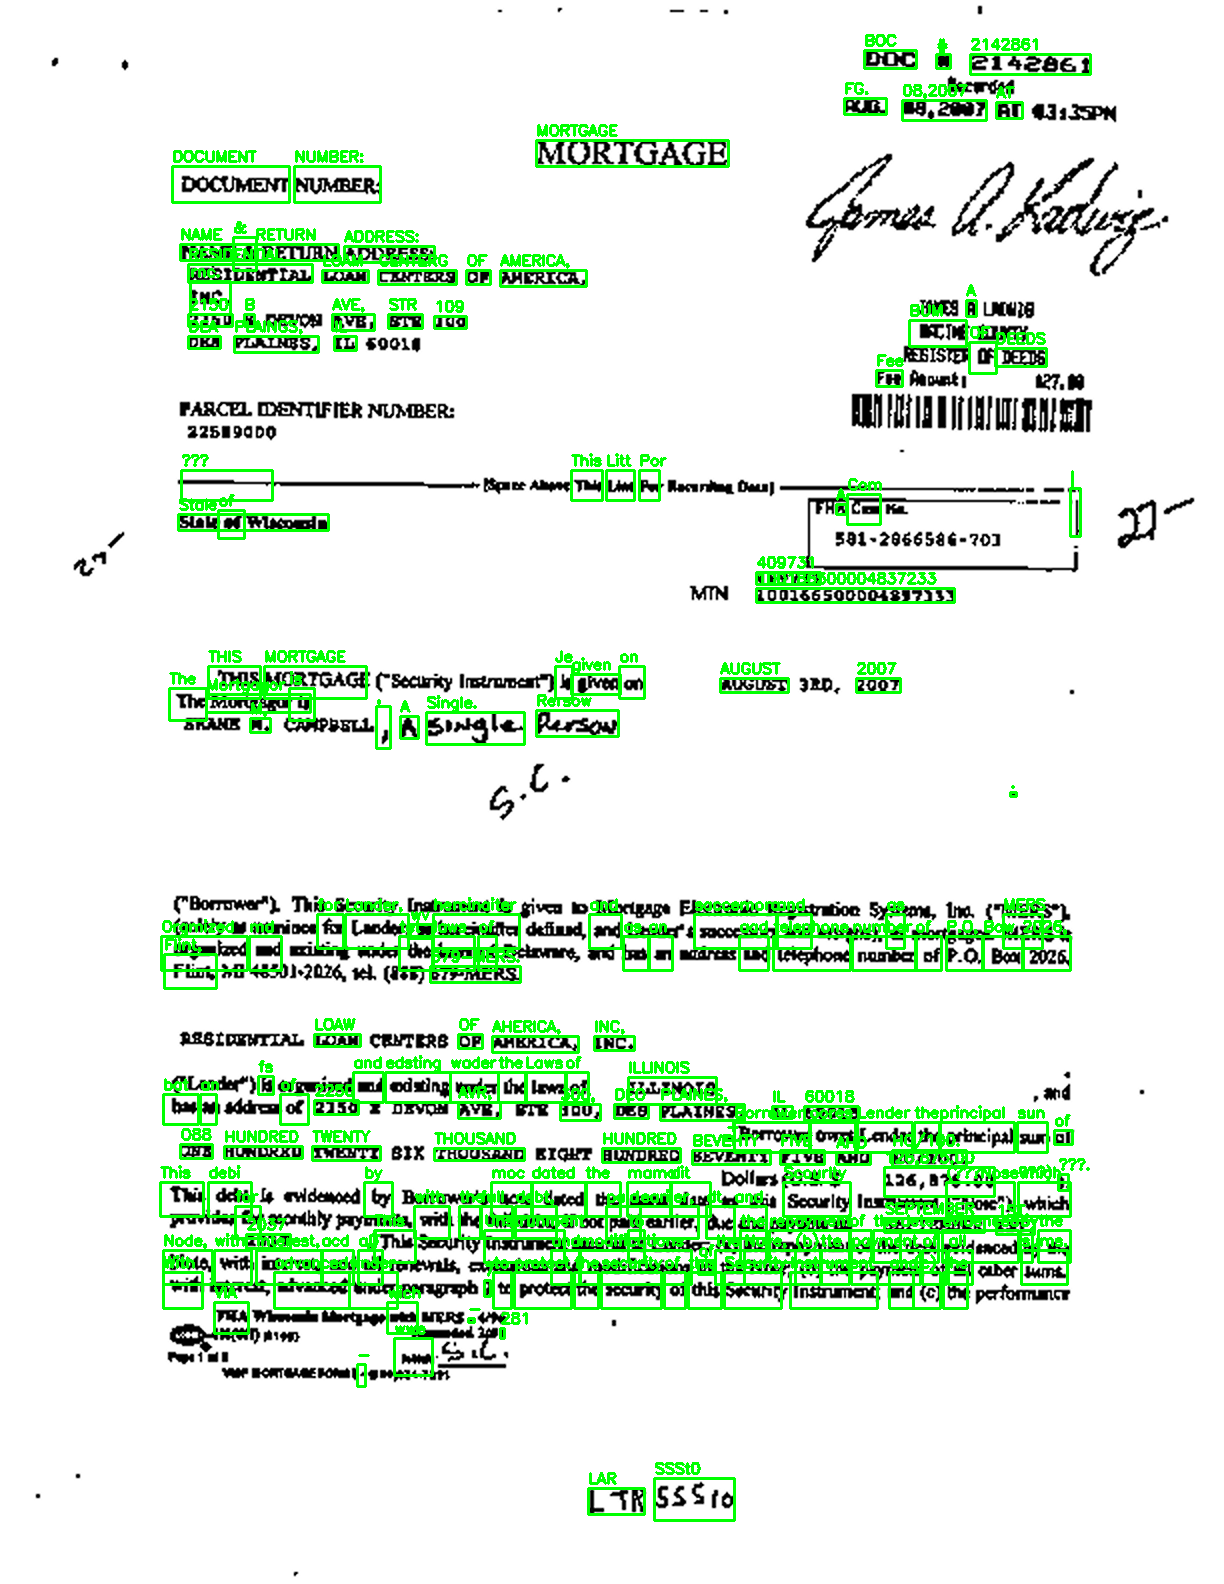

In [ ]:
import cv2
from PIL import Image

# Convert image to OpenCV BGR format
img_bgr = cv2.cvtColor(gray, cv2.COLOR_RGB2BGR)

# Get OpenCV image height for correct y-coordinate transformation
page_height = gray.shape[0]

# Define confidence threshold (ignore low-confidence words)
confidence_threshold = 40

# 📌 Step 9.1: Loop through Extracted OCR Words & Draw Bounding Boxes
for i in range(len(ocr_data["text"])):
    word = ocr_data["text"][i].strip()
    x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
    conf = int(ocr_data["conf"][i])  # Convert confidence to int

    # Ignore empty words & low-confidence OCR text
    if not word or conf < confidence_threshold:
        continue

    # Fix y-coordinate to match OpenCV's top-left origin
    #y = page_height - y

    # Draw bounding box
    cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_bgr, word, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# 📌 Step 9.2: Convert Back to RGB & Display the Image
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(img_rgb))





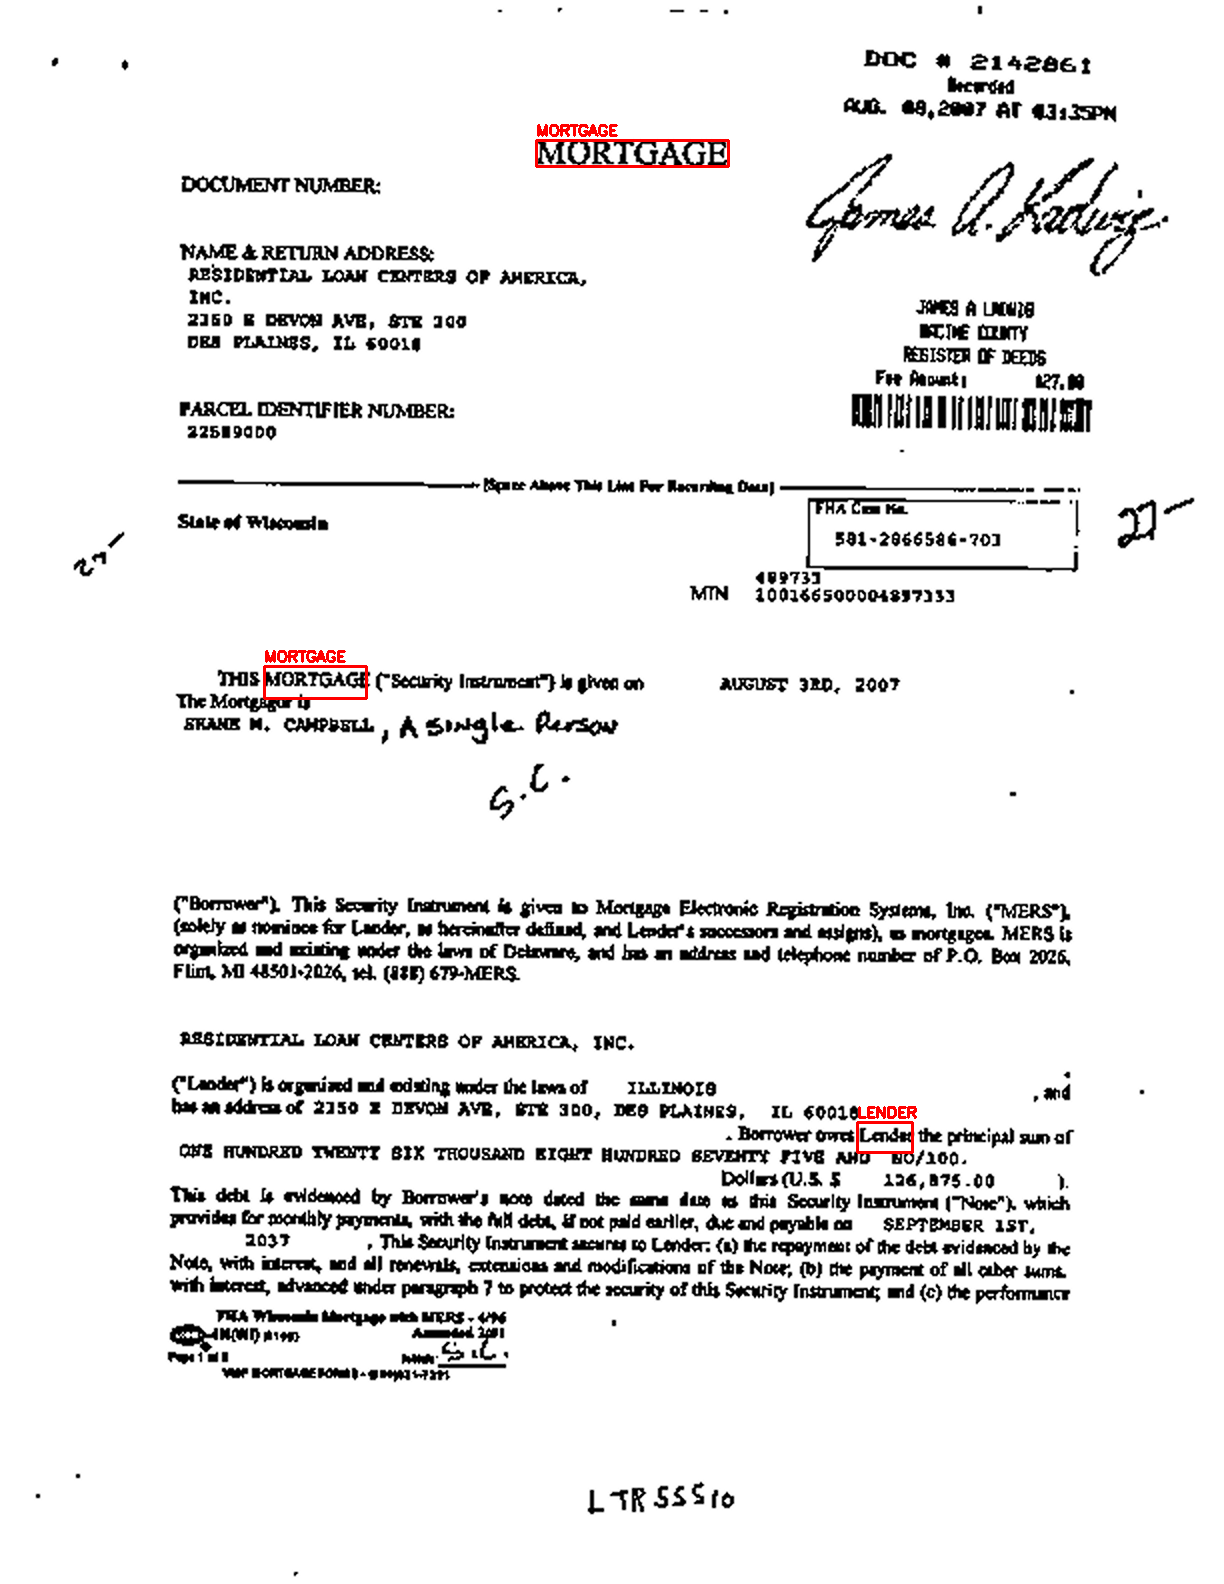

In [ ]:
# =======================
# 📌 Step 10: Draw Bounding Boxes on Relevant Key Fields from Mortgage Document
# =======================

import cv2

# Convert image to OpenCV BGR format
img_bgr = cv2.cvtColor(gray, cv2.COLOR_RGB2BGR)

# Define key fields dynamically based on document content
key_fields = ["MORTGAGE", "NOTE", "LENDER", "PROPERTY ADDRESS", "DATE", "SIGNATURE"]

# Loop through extracted OCR words
for i in range(len(ocr_data["text"])):
    word = ocr_data["text"][i].strip().upper()  # Convert to uppercase for better matching
    x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]

    if word in key_fields:  # Highlight only key fields found in the document
        cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box
        cv2.putText(img_bgr, word, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Convert back to RGB for display
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(img_rgb))

In [ ]:
import json

# Initialize an empty dictionary to store extracted key field data
extracted_data = {}

# Loop through detected words to extract key fields
for i in range(len(ocr_data["text"])):
    word = ocr_data["text"][i].strip().upper()
    x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]

    if word in key_fields:
        extracted_data[word] = {
            "text": word,
            "bounding_box": [x, y, w, h]
        }

# Convert extracted data into JSON format
json_output = json.dumps(extracted_data, indent=4)

# Print structured JSON output
print(json_output)


{
    "MORTGAGE": {
        "text": "MORTGAGE",
        "bounding_box": [
            264,
            666,
            102,
            32
        ]
    },
    "LENDER": {
        "text": "LENDER",
        "bounding_box": [
            857,
            1122,
            55,
            30
        ]
    }
}
